# importation
***

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score , precision_recall_curve
import numpy as np
import seaborn as sns
from IPython.display import clear_output

# functions
***

load pictures from a folder ,which in that folder all of pictures for a specific class are in a folder with name of class on it, to a list.
* `path`: path of folder that we want to load.
* `size`: size of pictures we want to load. must be a tuple.
* `flag`: flag for cv2.imread.default = 1.

In [2]:
def load_pics(path , size : tuple[int , int] , flag = 1):
    listOFpics = [] # the list which we append our pics with their label into it
    Path = path # the path we want to load
    classes = os.listdir(Path) # all classes
    for class_ in classes:
        Path_of_pics = os.path.join(Path , class_)
        pics_name = os.listdir(Path_of_pics)
        for pic_name in pics_name:
            pic_Path = os.path.join(Path_of_pics , pic_name)
            pic = cv2.imread(pic_Path , flags = flag)
            resized_pic = cv2.resize(pic , size)
            listOFpics.append([resized_pic , class_])
    return listOFpics

we have two labels. `NORMAL` and `PNEUMONIA`. this function assign 1 to `PNEUMONIA` and 0 to `NORMAL`

In [3]:
def strTOint(listOFstr):
    for i in range(len(listOFstr)):
        if listOFstr[i] == 'NORMAL':
            listOFstr[i] = 0
        else:
            listOFstr[i] = 1
    return np.asarray(listOFstr).reshape(-1 , 1)

# loading
***

my gpu couldn't handle size more than 500 so i chose that and since my VGG19 ,which i chose for doing transfer learning, only accept inputs with channel = 3 and that means i cant train on grayscale pictures. so i had to chose flag = 1.

In [4]:
train = load_pics(path = 'D:\datasets\Pneumonia\chest_xray\\train' , size = (500 , 500) , flag = 1)
test = load_pics(path = 'D:\datasets\Pneumonia\chest_xray\\test' , size = (500 , 500) , flag = 1)
val = load_pics(path = 'D:\datasets\Pneumonia\chest_xray\\val' , size = (500 , 500) , flag = 1)

In [ ]:
x_train = np.asarray([train[i][0].reshape(500 , 500 , -1) for i in range(len(train))])
y_train = [train[i][1] for i in range(len(train))]
y_train = strTOint(y_train)

x_test = np.asarray([test[i][0].reshape(500 , 500 , -1) for i in range(len(test))])
y_test = [test[i][1] for i in range(len(test))]
y_test = strTOint(y_test)

x_val = np.asarray([val[i][0].reshape(500 , 500 , -1) for i in range(len(val))])
y_val = [val[i][1] for i in range(len(val))]
y_val = strTOint(y_val)

lets look at our data and have a insight of our data

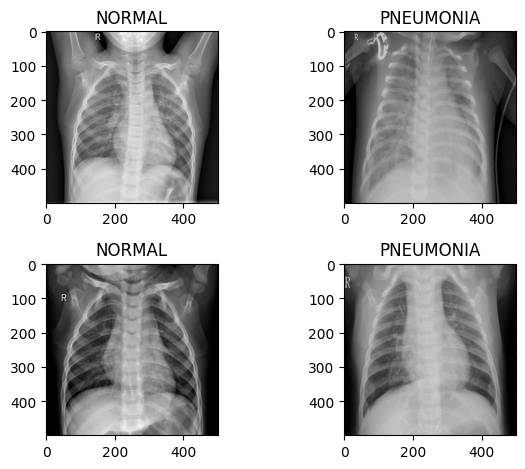

In [23]:
fig , [[ax1 , ax2] , [ax3 , ax4]] = plt.subplots(ncols = 2 , nrows = 2)

ax1.imshow(train[0][0])
ax2.imshow(train[1341][0])
ax3.imshow(train[1][0])
ax4.imshow(train[1342][0])

ax1.set_title('NORMAL')
ax2.set_title('PNEUMONIA')
ax3.set_title('NORMAL')
ax4.set_title('PNEUMONIA')

plt.tight_layout()
plt.show()

as we can see in that pie chart our data is imbalanced but its not that severe so we'll train on that and if results was not good we'll try other ways.

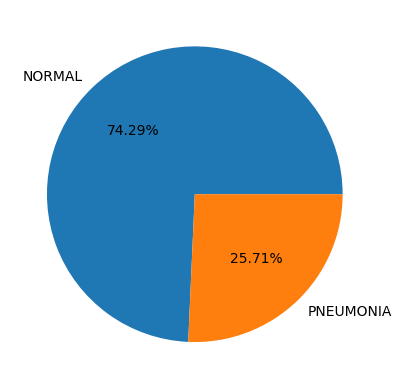

In [6]:
class_values = pd.DataFrame(y_train).value_counts()

plt.pie(class_values , labels = ['NORMAL' , 'PNEUMONIA'] , autopct = '%1.2f%%')
plt.show()

and we begin our guess game :)

In [4]:
import keras.applications
import keras.constraints
import keras.layers
import keras.optimizers

transfer_model = keras.applications.EfficientNetB3(include_top = False , input_shape = (500 , 500 , 3) , classes = 2 , classifier_activation = 'sigmoid')
transfer_model.trainable = False

flatten = keras.layers.Flatten()(transfer_model.layers[-1].output)
dns1 = keras.layers.Dense(32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(flatten)
dns2 = keras.layers.Dense(256 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(dns1)
dns3 = keras.layers.Dense(512 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(dns2)
dns4 = keras.layers.Dense(256 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(dns3)
dns5 = keras.layers.Dense(64 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(dns4)
dns6 = keras.layers.Dense(1 , activation = 'sigmoid' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.7))(dns5)

model = keras.Model(transfer_model.input , dns6)
model.compile(loss = 'binary_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , metrics = 'accuracy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 500, 500, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 500, 500, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [4]:
history = model.fit(x_train , y_train , validation_data = (x_val , y_val) , epochs = 5 , batch_size = 20)

Epoch 1/5
261/261 [==============================] - 79s 279ms/step - loss: 0.2017 - accuracy: 0.9496 - val_loss: 0.1282 - val_accuracy: 0.8750
Epoch 2/5
261/261 [==============================] - 72s 278ms/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/5
261/261 [==============================] - 72s 278ms/step - loss: 0.0392 - accuracy: 0.9916 - val_loss: 1.4459 - val_accuracy: 0.6875
Epoch 4/5
261/261 [==============================] - 73s 278ms/step - loss: 0.0549 - accuracy: 0.9908 - val_loss: 6.5932e-04 - val_accuracy: 1.0000
Epoch 5/5
261/261 [==============================] - 72s 278ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 9.7982e-04 - val_accuracy: 1.0000


<Axes: >

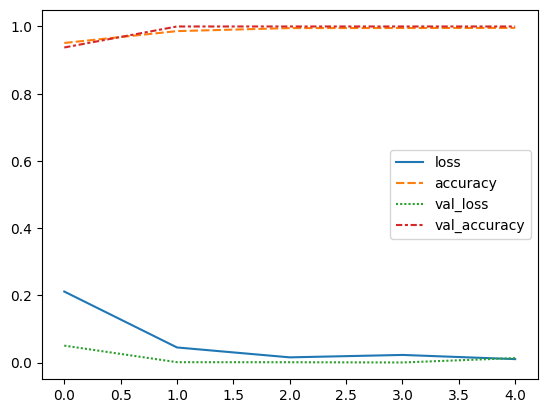

In [15]:
sns.lineplot(history.history)

# Test
***

In [7]:
prediction = model.predict(x_test)
clear_output()

we gotta find best threshold for our predictions so we use `precision_recall_curve` for finding precision and recall for different thresholds. as we know f1 score is harmonic mean of precision and recall so we calculate f1 scores for each threshold and find the threshold which gives us the best f1 score

In [8]:
precision , recall , threshold = precision_recall_curve(y_true = y_test , probas_pred = prediction)
f1scores = (2 * precision * recall) / (precision + recall)
f1_ind = np.nanargmax(f1scores)
TheThresholhd = threshold[f1_ind]
clear_output()

that red cross is the point which gives us best f1 score

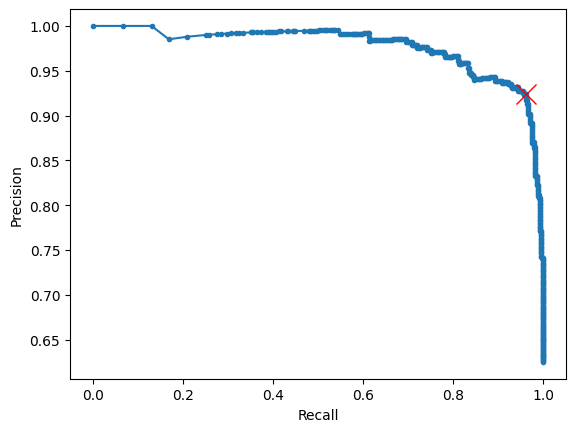

In [9]:
plt.plot(recall , precision , marker = '.')
plt.plot(recall[f1_ind] , precision[f1_ind] , 'rx' , markersize = 15)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

since our average and global accuracy is very close and with 0.9236 f1 score in mind we can say our model did a pretty good job at learning so we dont need to do anything more because of results this model gave us on imbalanced data. so we being imbalanced didnt give us much trouble after all.

In [10]:
binary_pred = np.where(prediction >= TheThresholhd , 1 , 0)
global_acc = accuracy_score(y_true = y_test , y_pred = binary_pred) * 100
conf = confusion_matrix(y_true = y_test , y_pred = binary_pred)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 
f1 = f1_score(y_true = y_test , y_pred = binary_pred)
precision_score = precision[f1_ind]
recall_score = recall[f1_ind]

print(f'global accuracy: {global_acc}%\n')
print(f'average accuracy: {avg_acc}%\n')
print(f'f1 score: {f1}\n')
print(f'precision: {precision_score}%\n')
print(f'recall: {recall_score}%\n')

global accuracy: 92.62820512820514%

average accuracy: 91.45299145299145%

f1 score: 0.9422110552763819

precision: 0.9236453201970444%

recall: 0.9615384615384616%



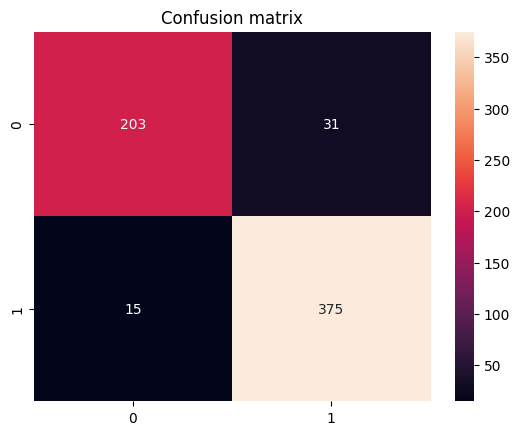

In [12]:
sns.heatmap(conf , fmt = '.0f' , annot = True)
plt.title('Confusion matrix')
plt.show()

## and we end up with a fine model